## Vanilla Policy Optimisation

<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G/blob/main/days/w1d5/vanilla_policy_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preliminary questions:
- Run the script with the defaults parameters on the terminal
- Explain from torch.distributions.categorical import Categorical
- google gym python, why is it useful?
- Policy gradient is model based or model free?
- Is policy gradient on-policy or off-policy?

Read all the code, then:
- Complete the ... in the compute_loss function.
- Use https://github.com/patrick-kidger/torchtyping to type the functions get_policy, get_action. You can draw inspiration from the compute_loss function.
- Answer the questions


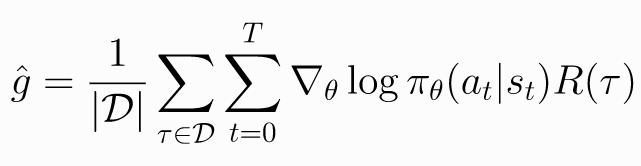

Policy gradient : if the sign of the reward is positive, then i want to take the policy more often.
if the sign is negative, i will optimize in the opposite way

## Batch size 

https://ai.stackexchange.com/questions/11640/how-large-should-the-replay-buffer-be

Buffer lenght for experience replay 

The longer the more stable but slower 

In [ ]:
! pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 50.4 MB/s eta 0:00:00


In [ ]:
!pip install torchtyping

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1


In [ ]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
import numpy as np
import gym
from gym.spaces import Discrete, Box

from torchtyping import TensorType, patch_typeguard
from typeguard import typechecked

patch_typeguard()  # use before @typechecked


def mlp(sizes, activation=nn.Tanh, output_activation=nn.Identity):
    # Build a feedforward neural network.
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    # What does * mean here? Search for unpacking in python
    # unpack list elements
    return nn.Sequential(*layers)

def train(env_name='CartPole-v0', hidden_sizes=[32], lr=1e-2, 
          epochs=50, batch_size=5000, render=False):

    # make environment, check spaces, get obs / act dims
    env = gym.make(env_name)
    assert isinstance(env.observation_space, Box), \
        "This example only works for envs with continuous state spaces."
    assert isinstance(env.action_space, Discrete), \
        "This example only works for envs with discrete action spaces."

    obs_dim = env.observation_space.shape[0]
    n_acts = env.action_space.n

    # Core of policy network
    # What should be the sizes of the layers of the policy network?
    logits_net = mlp(sizes=[obs_dim]+hidden_sizes+[n_acts])

    # make function to compute action distribution
    # construct log-probabilities and probabilities for actions
    # Categorical : a method for sampling from the distribution and for computing log probabilities of given samples
    # What is the shape of obs?
    @typechecked # To be typed
    def get_policy(obs: TensorType[..., obs_dim]):
        # Warning: obs has not always the same shape.
        logits = logits_net(obs)
        return Categorical(logits=logits)

    # make action selection function (outputs int actions, sampled from policy)
    # samples actions based on probabilities computed from the logits.
    # What is the shape of obs?
    @typechecked # To be typed
    def get_action(obs: TensorType[obs_dim]) -> float:
        return get_policy(obs).sample().item()

    # make loss function whose gradient, for the right data, is policy gradient
    # Right data : a set of (state, action, weight) tuples collected while acting according to the current policy
    # where the weight for a state-action pair is the return from the episode to which it belongs
    # log prob : get the logarithmic probability (logprob) of one experiment sample (sample) under a specific distribution (dist).
    # What is the shape of obs?
    @typechecked
    def compute_loss(obs: TensorType["b", obs_dim], act: TensorType["b"], weights: TensorType["b"]):
        """TODO"""
        # https://stackoverflow.com/questions/54635355/what-does-log-prob-do
        # Help: weights is a vector piecewise constant containing the total reward of each episode.
        logprobs = get_policy(obs).log_prob(act)
        return -(logprobs * weights).mean()


    # make optimizer
    optimizer = Adam(logits_net.parameters(), lr=lr)

    # for training policy
    def train_one_epoch():
        # make some empty lists for logging.
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for R(tau) weighting in policy gradient
        batch_rets = []         # for measuring episode returns # What is the return?
        batch_lens = []         # for measuring episode lengths

        # reset episode-specific variables
        obs = env.reset()       # first obs comes from starting distribution 
        done = False            # signal from environment that episode is over
        ep_rews = []            # list for rewards accrued throughout ep

        # render first episode of each epoch
        finished_rendering_this_epoch = False

        # collect experience by acting in the environment with current policy
        while True:

            # rendering
            if (not finished_rendering_this_epoch) and render:
                env.render()

            # save obs
            batch_obs.append(obs.copy())

            # act in the environment
            act = get_action(torch.as_tensor(obs, dtype=torch.float32))
            obs, rew, done, _ = env.step(act)

            # save action, reward
            batch_acts.append(act)
            ep_rews.append(rew)

            if done:
                # if episode is over, record info about episode
                # Is the reward discounted?
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)

                # the weight for each logprob(a|s) is R(tau)
                # Why do we use a constant vector here?
                batch_weights += [ep_ret] * ep_len

                # reset episode-specific variables
                obs, done, ep_rews = env.reset(), False, []

                # won't render again this epoch
                finished_rendering_this_epoch = True

                # end experience loop if we have enough of it
                if len(batch_obs) > batch_size:
                    break

        # take a single policy gradient update step
        optimizer.zero_grad()
        batch_loss = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32),
                                  act=torch.as_tensor(batch_acts, dtype=torch.int32),
                                  weights=torch.as_tensor(batch_weights, dtype=torch.float32)
                                  )
        batch_loss.backward()
        optimizer.step()
        return batch_loss, batch_rets, batch_lens

    # training loop
    for i in range(epochs):
        batch_loss, batch_rets, batch_lens = train_one_epoch()
        print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
                (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))


In [2]:
train(env_name='CartPole-v0', hidden_sizes=[48], lr=1e-2, 
          epochs=100, batch_size=100, render=True)

c:\Users\emili\anaconda3\envs\ML4G\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(
C:\Users\emili\AppData\Local\Temp\ipykernel_22392\2992695900.py:134: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  batch_loss = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32),


epoch:   0 	 loss: 16.802 	 return: 22.000 	 ep_len: 22.000
epoch:   1 	 loss: 16.151 	 return: 18.333 	 ep_len: 18.333
epoch:   2 	 loss: 14.199 	 return: 18.833 	 ep_len: 18.833
epoch:   3 	 loss: 15.682 	 return: 22.000 	 ep_len: 22.000
epoch:   4 	 loss: 19.384 	 return: 26.000 	 ep_len: 26.000
epoch:   5 	 loss: 26.092 	 return: 38.000 	 ep_len: 38.000
epoch:   6 	 loss: 25.207 	 return: 31.800 	 ep_len: 31.800
epoch:   7 	 loss: 30.435 	 return: 37.667 	 ep_len: 37.667
epoch:   8 	 loss: 32.058 	 return: 45.333 	 ep_len: 45.333
epoch:   9 	 loss: 20.500 	 return: 29.000 	 ep_len: 29.000
epoch:  10 	 loss: 22.755 	 return: 33.667 	 ep_len: 33.667
epoch:  11 	 loss: 26.941 	 return: 41.667 	 ep_len: 41.667
epoch:  12 	 loss: 26.791 	 return: 42.000 	 ep_len: 42.000
epoch:  13 	 loss: 23.815 	 return: 38.667 	 ep_len: 38.667
epoch:  14 	 loss: 34.324 	 return: 49.667 	 ep_len: 49.667
epoch:  15 	 loss: 31.542 	 return: 46.333 	 ep_len: 46.333
epoch:  16 	 loss: 36.429 	 return: 38.3

: 

In [ ]:
# Original algo here: https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/vpg/vpg.py